In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize 


In [2]:
def build_neuralnet(k, d, n):  
  # Define the layers of the neural network
  input_layer = tf.keras.layers.Input(shape = (k,))
  hidden_layers = []
  for i in range(d): 
      if i == 0:
          hidden_layers.append(tf.keras.layers.Dense(k+ 10 * (i + 1), activation='relu')(input_layer))
      else:
          hidden_layers.append(tf.keras.layers.Dense(k + 10 * (i + 1), activation='relu')(hidden_layers[-1]))
          
  output_layer = tf.keras.layers.Dense(n, activation='relu')(hidden_layers[-1])

  # Create the model
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

  # Compile the model
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
  return model


# Define the loss function
def loss_func(x, y, A):
  loss = 0 
  y_hat = A @ x
  for i in range(len(y)): 
    loss += ( y[i] - y_hat[i]) ** 2
  return loss


def random_unit_vector(dim):
    vec = np.random.normal(0, 1, dim).reshape(1,-1)
    return vec / np.linalg.norm(vec)

def monte_carlo_optimization(f, n_samples, inputdim):
    min_x = None
    min_f = float('inf')
    for i in range(n_samples):
        z = random_unit_vector(inputdim)
        x_hat = model.predict(z, verbose = 0).transpose()
        f_val = f(x_hat,y,A)
        if f_val < min_f:
            min_f = f_val
            min_x = x_hat
    return min_x, min_f

In [61]:
# Use gradient descent optimization to minimize the square loss function
def gradient_descent(z_input,A, y, model, learning_rate = 0.1, num_iterations = 1000):
  loss_history = []
  for i in range(num_iterations):
      with tf.GradientTape() as tape:
          tape.watch(z_input)
          pred = model(z_input)
          loss = tf.reduce_sum(tf.square(y - A @ tf.transpose(pred)) )
      loss_history.append(loss.numpy())
      gradients = tape.gradient(loss, z_input)
      z_input = z_input - learning_rate * gradients #Update the value according to gradient descent
  return z_input, loss_history

def stochastic_gradient_descent(z_input, A, y, model, learning_rate=0.1, batch_size=32, num_epochs=100):
    num_samples = A.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))
    loss_history = []
    for epoch in range(num_epochs):
        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = min((batch + 1) * batch_size, num_samples)
            batch_A = A[start_idx:end_idx, :]
            batch_y = y[start_idx:end_idx, :]
            with tf.GradientTape() as tape:
                tape.watch(z_input)
                pred = model(z_input)
                loss = tf.reduce_sum(tf.square(batch_y - batch_A @ tf.transpose(pred)))
            loss_history.append(loss.numpy())
            gradients = tape.gradient(loss, z_input)
            z_input = z_input - learning_rate * gradients
    return z_input, loss_history
  

def adam_optimization(z_input, A, y, model, learning_rate=0.01, num_iterations=1000):
    loss_history = []
    z_input = tf.Variable(z_input)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(z_input)
            pred = model(z_input)
            loss = tf.reduce_sum(tf.square(y - A @ tf.transpose(pred)))
        loss_history.append(loss.numpy())
        gradients = tape.gradient(loss, z_input)
        optimizer.apply_gradients(zip([gradients], [z_input]))
    return z_input.numpy(), loss_history


def find_min_M(d, k, n, step_M, min_M, max_M, num_trials, target_error):
    # Set the input shape and depth of the neural network
    input_shape = (1,k )
    depth = d
    # Define the model and the true signal
    model = build_neuralnet(k, d, n)
    z_latent = tf.random.normal(shape=(1,k))
    x_true = model.predict(z_latent)
    # Study the number of sample size needed to recover the signal
    for M in range(min_M, max_M + 1, step_M):
        success_rate = 0.0
        average_error = 0.0
        w = np.random.normal(loc=0, scale=1/M, size=(M, 1))
        for i in range(num_trials):
            # Define the measurements
            A = np.random.normal(loc=0, scale=np.sqrt(1), size=(M, n))
            y = A @ x_true.transpose() + w
            # Find the minimum
            min_z, loss = adam_optimization(tf.random.normal(shape=input_shape), A, y, model, learning_rate=0.01, num_iterations=1000)
            # Calculate the error
            error = np.linalg.norm(model.predict(min_z, verbose=0) - x_true)
            if error < target_error:
                return M    
    return None

def simulation(k,d,n, min_M, max_M, step_M, num_trials):
  reconstruction_errors = []
  model= build_neuralnet(k,d,n)
  for M in range(min_M, max_M+1, step_M):
    print("Simulating for M:", M)
    success_rate = 0.0
    average_error = 0.0
    w = np.random.normal(loc=0, scale=1/M, size = (M, 1))
    for i in range(num_trials):
      #Define The measurements
      A = np.random.normal(loc=0, scale=np.sqrt(1),size = (M, n))
      y = A @ x_true.transpose() + w
      # Find the minimum 
      min_z, loss = adam_optimization(tf.random.normal(shape=(1,k)), A, y, model, learning_rate=0.1, num_iterations=10000)
      error = np.linalg.norm(model.predict(min_z, verbose = 0) - x_true) 
      if error < 1e-3:
          success_rate += 1.0
      average_error += error
    success_rate /= num_trials; average_error /= num_trials
    reconstruction_errors.append(average_error)
    plt.plot(loss)
    plt.title('optimizing loss')
  fig = plt.figure()
  plt.plot(range(min_M, max_M+1, step_M), reconstruction_errors)
  plt.xlabel('Number of Measurements')
  plt.ylabel('Reconstruction Error (MSE)')
  plt.title('Reconstruction Error vs. Number of Measurements')
  plt.show()



In [ ]:
#Usual compressed sensing
reconstruction_errors = []
n = 100
x_true = np.random.normal(size = (n, 1))
# Study the number of sample size needed to recovery the signal
step_M = 10; min_M = 10; max_M = 400;num_trials = 10
for M in range(min_M, max_M+1, step_M):
  success_rate = 0.0
  average_error = 0.0
  w = np.random.normal(size=(M,1))
  print("Simulating for M=", M)
  for i in range(num_trials):
    #Define The measurements
    A = np.random.normal(loc=0, scale=np.sqrt(1),size = (M, n))
    y = A @ x_true + w
    #the solution that minimizes the square loss function
    res = scipy.optimize.minimize(loss_func, np.zeros((n, )), args=(y, A)) 
    min_x = res.x.reshape(-1,1)
    error = np.linalg.norm(min_x - x_true)
    if error < 1e-3:
        success_rate += 1.0
    average_error += error
  success_rate /= num_trials; average_error /= num_trials
  reconstruction_errors.append(average_error)
  print(f'M = {M}, success rate = {success_rate}, average error = {average_error}')

In [69]:
# Define the input parameters
k = 50 #input shape
n = 100 #The dimension of the output of Neural network
step_M = 10
min_M = 10
max_M = 200
num_trials = 10
target_error = 1e-1

# Loop through every value of d and find the minimum M required
for d in range(1, 20):
    min_M_d = find_min_M(d, k, n, step_M, min_M, max_M, num_trials, target_error)
    print(f'd = {d}, min_M = {min_M_d}')

1/1 [==============================] - 0s 47ms/step
d = 5, min_M = 40
1/1 [==============================] - 0s 67ms/step
d = 6, min_M = 30
1/1 [==============================] - 0s 78ms/step
d = 7, min_M = 30
1/1 [==============================] - 0s 80ms/step
d = 8, min_M = 20
1/1 [==============================] - 0s 88ms/step
d = 9, min_M = 10
1/1 [==============================] - 0s 84ms/step
d = 10, min_M = 10
1/1 [==============================] - 0s 94ms/step
d = 11, min_M = 10
1/1 [==============================] - 0s 93ms/step
d = 12, min_M = 10
1/1 [==============================] - 0s 98ms/step
d = 13, min_M = 10
1/1 [==============================] - 0s 100ms/step
d = 14, min_M = 10


In [79]:
# Define the input parameters
d = 5 #input shape
n = 100 #The dimension of the output of Neural network
step_M = 50
min_M = 50
max_M = 1000
num_trials = 10
target_error = 1e-1

# Loop through every value of d and find the minimum M required
for k in range(10, 100, 10):
    min_M_k = find_min_M(d, k, n, step_M, min_M, max_M, num_trials, target_error)
    print(f'k = {k}, min_M = {min_M_k}')

1/1 [==============================] - 0s 48ms/step
k = 10, min_M = 50
1/1 [==============================] - 0s 61ms/step
k = 20, min_M = 50
1/1 [==============================] - 0s 62ms/step
k = 30, min_M = 50
1/1 [==============================] - 0s 62ms/step
k = 40, min_M = 250
1/1 [==============================] - 0s 62ms/step
k = 50, min_M = 200
1/1 [==============================] - 0s 62ms/step
k = 60, min_M = 100
1/1 [==============================] - 0s 63ms/step
k = 70, min_M = 100
1/1 [==============================] - 0s 63ms/step
k = 80, min_M = 450
1/1 [==============================] - 0s 62ms/step
k = 90, min_M = 150


In [86]:
min_M= 100
max_M = 500
# Loop through every value of d and find the minimum M required
for k in range(100, 200, 10):
    min_M_k = find_min_M(d, k, n, step_M, min_M, max_M, num_trials, target_error)
    print(f'k = {k}, min_M = {min_M_k}')

1/1 [==============================] - 0s 48ms/step
k = 100, min_M = 350
1/1 [==============================] - 0s 62ms/step
k = 110, min_M = 100
1/1 [==============================] - 0s 63ms/step
k = 120, min_M = 200
1/1 [==============================] - 0s 62ms/step
k = 130, min_M = 100
1/1 [==============================] - 0s 63ms/step
k = 140, min_M = 150
1/1 [==============================] - 0s 62ms/step
k = 150, min_M = 300
1/1 [==============================] - 0s 64ms/step
k = 160, min_M = 350
1/1 [==============================] - 0s 62ms/step
k = 170, min_M = 300
1/1 [==============================] - 0s 61ms/step
k = 180, min_M = 150
1/1 [==============================] - 0s 62ms/step
k = 190, min_M = 350


In [78]:
# Define the input parameters
d = 5 #input shape
k = 10 #The dimension of the output of Neural network
step_M = 50
min_M = 50
max_M = 500
num_trials = 10
target_error = 1e-1

# Loop through every value of d and find the minimum M required
for n in range(100, 1000, 100):
    min_M_n = find_min_M(d, k, n, step_M, min_M, max_M, num_trials, target_error)
    print(f'n = {n}, min_M = {min_M_n}')

1/1 [==============================] - 0s 50ms/step
n = 100, min_M = 50
1/1 [==============================] - 0s 61ms/step
n = 200, min_M = 50
1/1 [==============================] - 0s 63ms/step
n = 300, min_M = 50
1/1 [==============================] - 0s 61ms/step
n = 400, min_M = 50
1/1 [==============================] - 0s 63ms/step
n = 500, min_M = 100
1/1 [==============================] - 0s 61ms/step
n = 600, min_M = 50
1/1 [==============================] - 0s 61ms/step
n = 700, min_M = 50
1/1 [==============================] - 0s 61ms/step
n = 800, min_M = 50
1/1 [==============================] - 0s 63ms/step
n = 900, min_M = 50


Simulating for M: 10
Simulating for M: 20
Simulating for M: 30
Simulating for M: 40
Simulating for M: 50
Simulating for M: 60
Simulating for M: 70
Simulating for M: 80
Simulating for M: 90
Simulating for M: 100
Simulating for M: 110
Simulating for M: 120
Simulating for M: 130
Simulating for M: 140
Simulating for M: 150
Simulating for M: 160
Simulating for M: 170
Simulating for M: 180
Simulating for M: 190
Simulating for M: 200


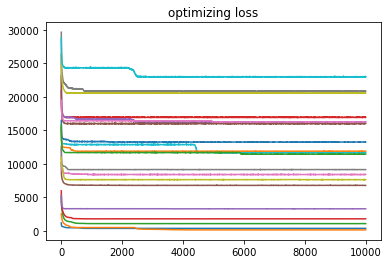

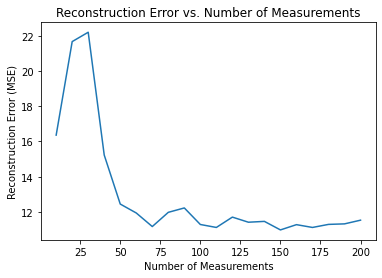

In [47]:
# Set the input shape
k = 50 #input shape
d = 2 #Depth of the neural network 
n = 100 #The dimension of the output of Neural network

# Study the number of sample size needed to recovery the signal
step_M = 10; min_M = 10; max_M = 200;num_trials = 1
x_true = np.random.normal(size=(1,n))
simulation(k,d,n, min_M, max_M, step_M, num_trials)

Simulating for M: 10
Simulating for M: 20
Simulating for M: 30
Simulating for M: 40
Simulating for M: 50
Simulating for M: 60
Simulating for M: 70
Simulating for M: 80
Simulating for M: 90
Simulating for M: 100
Simulating for M: 110
Simulating for M: 120
Simulating for M: 130
Simulating for M: 140
Simulating for M: 150
Simulating for M: 160
Simulating for M: 170
Simulating for M: 180
Simulating for M: 190
Simulating for M: 200


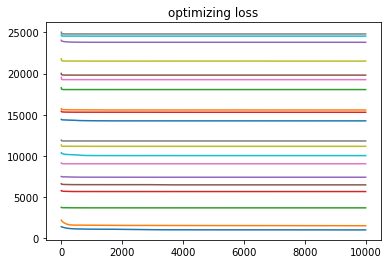

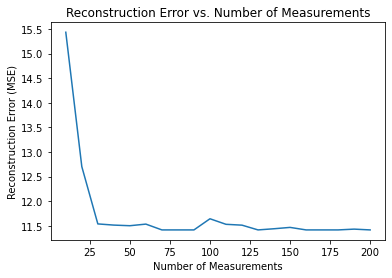

In [48]:
# Set the input shape
k = 50 #input shape
d = 10 #Depth of the neural network 
n = 100 #The dimension of the output of Neural network

# Study the number of sample size needed to recovery the signal
step_M = 10; min_M = 10; max_M = 200;num_trials = 1

simulation(k,d,n, min_M, max_M, step_M, num_trials)

In [ ]:
# Set the input shape
k = 50 #input shape
d = 2 #Depth of the neural network 
n = 100 #The dimension of the output of Neural network

model= build_neuralnet(k,d,n)
model.summary()

#Define the true signal
z_latent = tf.random.normal(shape=(1,k))
x_true = model.predict(z_latent)



In [ ]:
# Study the number of sample size needed to recovery the signal
step_M = 10; min_M = 10; max_M = 400;num_trials = 10
reconstruction_errors = []

for M in range(min_M, max_M+1, step_M):
  success_rate = 0.0
  average_error = 0.0
  w = np.random.normal(loc=0, scale=1/M, size = (M, 1))
  for i in range(num_trials):
    #Define The measurements
    A = np.random.normal(loc=0, scale=np.sqrt(1),size = (M, n))
    y = A @ x_true.transpose() + w
    # Find the minimum 
    min_z, loss = adam_optimization(tf.random.normal(shape=(1,k)), A, y, model, learning_rate=0.01, num_iterations=1000)
    error = np.linalg.norm(model.predict(min_z, verbose = 0) - x_true) 
    if error < 1e-3:
        success_rate += 1.0
    average_error += error
  success_rate /= num_trials; average_error /= num_trials
  reconstruction_errors.append(average_error)
  print(f'M = {M}, success rate = {success_rate}, average error = {average_error}')

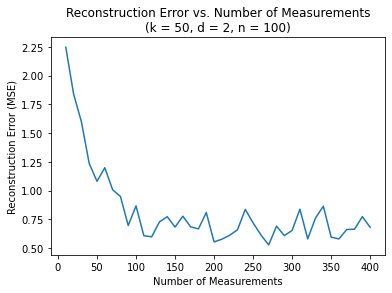

In [ ]:
num_measurements = range(min_M, max_M+1, step_M)
plt.plot(num_measurements, reconstruction_errors)
plt.xlabel('Number of Measurements')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs. Number of Measurements\n(k = 50, d = 2, n = 100)')
plt.show()

In [ ]:
# Set the input shape
k = 50 #input shape
d = 5 #Depth of the neural network 
n = 100 #The dimension of the output of Neural network
model= build_neuralnet(k,d,n)
#Define the true signal
z_latent = tf.random.normal(shape=(1,k))
x_true = model.predict(z_latent)

# Study the number of sample size needed to recovery the signal
step_M = 10; min_M = 10; max_M = 200;num_trials = 10
reconstruction_errors = []

for M in range(min_M, max_M+1, step_M):
  success_rate = 0.0
  average_error = 0.0
  w = np.random.normal(loc=0, scale=1/M, size = (M, 1))
  for i in range(num_trials):
    #Define The measurements
    A = np.random.normal(loc=0, scale=np.sqrt(1),size = (M, n))
    y = A @ x_true.transpose() + w
    # Find the minimum 
    min_z, loss = adam_optimization(tf.random.normal(shape=(1,k)), A, y, model, learning_rate=0.01, num_iterations=1000)
    error = np.linalg.norm(model.predict(min_z, verbose = 0) - x_true) 
    if error < 1e-3:
        success_rate += 1.0
    average_error += error
  success_rate /= num_trials; average_error /= num_trials
  reconstruction_errors.append(average_error)
  print(f'M = {M}, success rate = {success_rate}, average error = {average_error}')

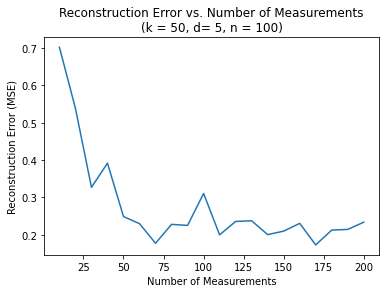

In [ ]:
num_measurements = range(min_M, max_M+1, step_M)
plt.plot(num_measurements, reconstruction_errors)
plt.xlabel('Number of Measurements')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs. Number of Measurements\n(k = 50, d= 5, n = 100)')
plt.show()

1/1 [==============================] - 0s 72ms/step


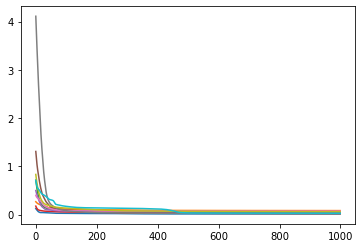

In [56]:
# Set the input shape
k = 50 #input shape
d = 10 #Depth of the neural network 
n = 100 #The dimension of the output of Neural network

model= build_neuralnet(k,d,n)
#Define the true signal
z_latent = tf.random.normal(shape=(1,k))
x_true = model.predict(z_latent)


# Study the number of sample size needed to recovery the signal
step_M = 10; min_M = 10; max_M = 100;num_trials = 10
reconstruction_errors = []

for M in range(min_M, max_M+1, step_M):
  success_rate = 0.0
  average_error = 0.0
  w = np.random.normal(loc=0, scale=1/M, size = (M, 1))
  for i in range(num_trials):
    #Define The measurements
    A = np.random.normal(loc=0, scale=np.sqrt(1),size = (M, n))
    y = A @ x_true.transpose() + w
    # Find the minimum 
    min_z, loss = adam_optimization(tf.random.normal(shape=(1,k)), A, y, model, learning_rate=0.01, num_iterations=1000)
    error = np.linalg.norm(model.predict(min_z, verbose = 0) - x_true) 
    if error < 1e-3:
        success_rate += 1.0
    average_error += error
  success_rate /= num_trials; average_error /= num_trials
  reconstruction_errors.append(average_error)
  plt.plot(loss)

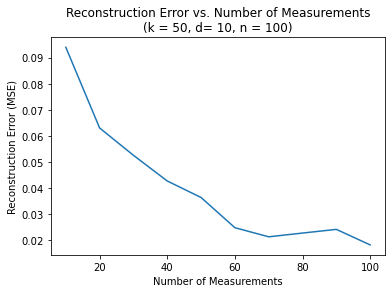

In [57]:
num_measurements = range(min_M, max_M + 1, step_M)
plt.plot(num_measurements, reconstruction_errors)
plt.xlabel('Number of Measurements')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs. Number of Measurements\n(k = 50, d= 10, n = 100)')
plt.show()

In [ ]:
# Set the input shape
k = 100 #input shape
d = 2 #Depth of the neural network 
n = 100 #The dimension of the output of Neural network

model= build_neuralnet(k,d,n)
#Define the true signal
z_latent = tf.random.normal(shape=(1,k))
x_true = model.predict(z_latent)

# Study the number of sample size needed to recovery the signal
step_M = 20; min_M = 10; max_M = 410;num_trials = 10
reconstruction_errors = []

for M in range(min_M, max_M+1, step_M):
  success_rate = 0.0
  average_error = 0.0
  w = np.random.normal(loc=0, scale=1/M, size = (M, 1))
  for i in range(num_trials):
    #Define The measurements
    A = np.random.normal(loc=0, scale=np.sqrt(1),size = (M, n))
    y = A @ x_true.transpose() + w
    # Find the minimum 
    min_z, loss = adam_optimization(tf.random.normal(shape=(1,k)), A, y, model, learning_rate=0.01, num_iterations=1000)
    error = np.linalg.norm(model.predict(min_z, verbose = 0) - x_true) 
    if error < 1e-3:
        success_rate += 1.0
    average_error += error
  success_rate /= num_trials; average_error /= num_trials
  reconstruction_errors.append(average_error)
  print(f'M = {M}, success rate = {success_rate}, average error = {average_error}')

1/1 [==============================] - 0s 37ms/step
M = 10, success rate = 0.0, average error = 2.816191840171814
M = 30, success rate = 0.0, average error = 2.113334429264069
M = 50, success rate = 0.0, average error = 1.2032919526100159
M = 70, success rate = 0.0, average error = 1.1832406759262084
M = 90, success rate = 0.0, average error = 0.8691003084182739
M = 110, success rate = 0.0, average error = 0.8041686654090882
M = 130, success rate = 0.0, average error = 0.8866413176059723
M = 150, success rate = 0.0, average error = 0.6660324454307556
M = 170, success rate = 0.0, average error = 0.7586236804723739
M = 190, success rate = 0.0, average error = 0.5107186079025269
M = 210, success rate = 0.0, average error = 0.6929153323173523
M = 230, success rate = 0.0, average error = 0.6521190762519836
M = 250, success rate = 0.0, average error = 0.640234300494194
M = 270, success rate = 0.0, average error = 0.6383393347263336
M = 290, success rate = 0.0, average error = 0.5088391214609

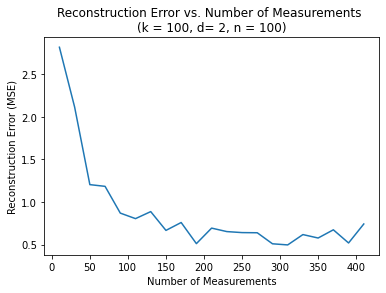

In [ ]:
num_measurements = range(min_M, max_M+1, step_M)
plt.plot(num_measurements, reconstruction_errors)
plt.xlabel('Number of Measurements')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs. Number of Measurements \n(k = 100, d= 2, n = 100)')
plt.show()

In [ ]:
# Set the input shape
k = 200 #input shape
d = 2 #Depth of the neural network 
n = 100 #The dimension of the output of Neural network

model= build_neuralnet(k,d,n)
#Define the true signal
z_latent = tf.random.normal(shape=(1,k))
x_true = model.predict(z_latent)

# Study the number of sample size needed to recovery the signal
step_M = 40; min_M = 600; max_M = 1000;num_trials = 10

for M in range(min_M, max_M+1, step_M):
  success_rate = 0.0
  average_error = 0.0
  w = np.random.normal(loc=0, scale=1/M, size = (M, 1))
  for i in range(num_trials):
    #Define The measurements
    A = np.random.normal(loc=0, scale=np.sqrt(1),size = (M, n))
    y = A @ x_true.transpose() + w
    # Find the minimum 
    min_z, loss = adam_optimization(tf.random.normal(shape=(1,k)), A, y, model, learning_rate=0.01, num_iterations=1000)
    error = np.linalg.norm(model.predict(min_z, verbose = 0) - x_true) 
    if error < 1e-3:
        success_rate += 1.0
    average_error += error
  success_rate /= num_trials; average_error /= num_trials
  reconstruction_errors.append(average_error)
  print(f'M = {M}, success rate = {success_rate}, average error = {average_error}')



1/1 [==============================] - 0s 37ms/step
M = 600, success rate = 0.0, average error = 0.8700220555067062
M = 640, success rate = 0.0, average error = 0.7127965956926345
M = 680, success rate = 0.0, average error = 1.2241025060415267
M = 720, success rate = 0.0, average error = 0.6822263166308403
M = 760, success rate = 0.0, average error = 0.527512076497078
M = 800, success rate = 0.0, average error = 0.8782349780201912
M = 840, success rate = 0.0, average error = 0.9623557269573212
M = 880, success rate = 0.0, average error = 0.9258247137069702
M = 920, success rate = 0.0, average error = 0.6699220266193151
M = 960, success rate = 0.0, average error = 0.7871535122394562
M = 1000, success rate = 0.0, average error = 0.6935937643051148


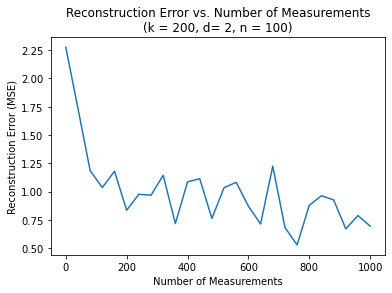

In [ ]:
num_measurements = range(0, max_M + 1, step_M)
plt.plot(num_measurements, reconstruction_errors)
plt.xlabel('Number of Measurements')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs. Number of Measurements\n(k = 200, d= 2, n = 100)')
plt.show()

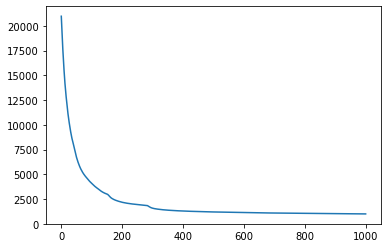

In [ ]:
plt.plot(loss)

In [ ]:
# Set the input shape
k = 100 #input shape
d = 2 #Depth of the neural network 
n = 500 #The dimension of the output of Neural network

model= build_neuralnet(k,d,n)
#Define the true signal
z_latent = tf.random.normal(shape=(1,k))
x_true = model.predict(z_latent)

# Study the number of sample size needed to recovery the signal
step_M = 10; min_M = 10; max_M = 400;num_trials = 10
reconstruction_errors = []

for M in range(min_M, max_M+1, step_M):
  success_rate = 0.0
  average_error = 0.0
  w = np.random.normal(loc=0, scale=1/M, size = (M, 1))
  for i in range(num_trials):
    #Define The measurements
    A = np.random.normal(loc=0, scale=np.sqrt(1),size = (M, n))
    y = A @ x_true.transpose() + w
    # Find the minimum 
    min_z, loss = adam_optimization(tf.random.normal(shape=(1,k)), A, y, model, learning_rate=0.01, num_iterations=1000)
    error = np.linalg.norm(model.predict(min_z, verbose = 0) - x_true) 
    if error < 1e-3:
        success_rate += 1.0
    average_error += error
  success_rate /= num_trials; average_error /= num_trials
  reconstruction_errors.append(average_error)
  print(f'M = {M}, success rate = {success_rate}, average error = {average_error}')


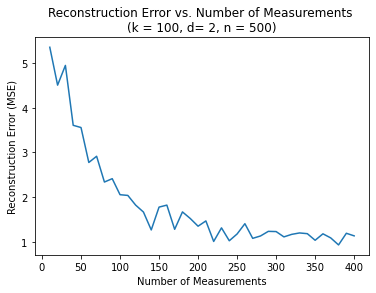

In [ ]:
num_measurements = range(min_M, max_M+1, step_M)
plt.plot(num_measurements, reconstruction_errors)
plt.xlabel('Number of Measurements')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs. Number of Measurements \n(k = 100, d= 2, n = 500)')
plt.show()

In [ ]:
# Set the input shape
k = 100 #input shape
d = 2 #Depth of the neural network 
n = 1000 #The dimension of the output of Neural network

model= build_neuralnet(k,d,n)
#Define the true signal
z_latent = tf.random.normal(shape=(1,k))
x_true = model.predict(z_latent)

# Study the number of sample size needed to recovery the signal
step_M = 20; min_M = 20; max_M = 400;num_trials = 10
reconstruction_errors = []

for M in range(min_M, max_M+1, step_M):
  success_rate = 0.0
  average_error = 0.0
  w = np.random.normal(loc=0, scale=1/M, size = (M, 1))
  for i in range(num_trials):
    #Define The measurements
    A = np.random.normal(loc=0, scale=np.sqrt(1),size = (M, n))
    y = A @ x_true.transpose() + w
    # Find the minimum 
    min_z, loss = adam_optimization(tf.random.normal(shape=(1,k)), A, y, model, learning_rate=0.01, num_iterations=1000)
    error = np.linalg.norm(model.predict(min_z, verbose = 0) - x_true) 
    if error < 1e-3:
        success_rate += 1.0
    average_error += error
  success_rate /= num_trials; average_error /= num_trials
  reconstruction_errors.append(average_error)
  print(f'M = {M}, success rate = {success_rate}, average error = {average_error}')

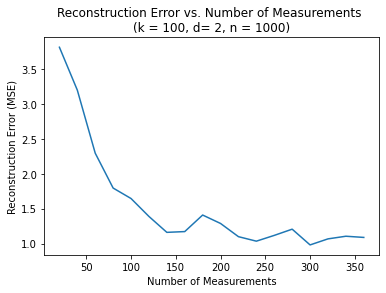

In [ ]:
num_measurements = range(min_M, 360+1, step_M)
plt.plot(num_measurements, reconstruction_errors)
plt.xlabel('Number of Measurements')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs. Number of Measurements \n(k = 100, d= 2, n = 1000)')
plt.show()

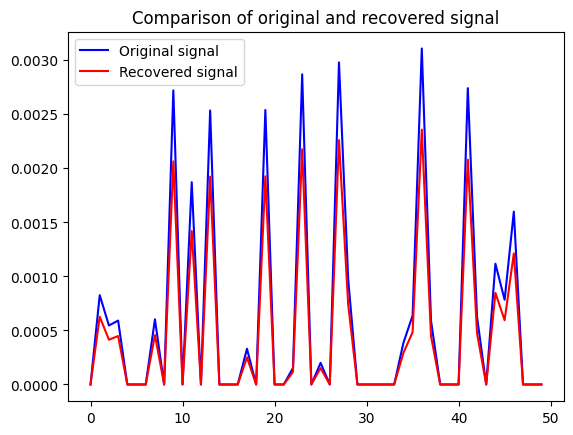

In [ ]:
#Visualize the plot 
import matplotlib.pyplot as plt

# Plot the original signal in blue
plt.plot(x_true, color='blue', label='Original signal')

# Plot the recovered signal in red
plt.plot(min_x, color='red', label='Recovered signal')

# Add title and legend
plt.title('Comparison of original and recovered signal')
plt.legend()

# Show the plot
plt.show()
